In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import random
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from math import radians, cos, sin, asin, sqrt

In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Read the Train Dataset

In [5]:
train = pd.read_csv("/content/drive/Shareddrives/eBay/train.tsv",sep = "\t")

In [ ]:
# Declared handling days have 702,886 null entries
train.isnull().sum()

b2c_c2c                           0
seller_id                         0
declared_handling_days       702886
acceptance_scan_timestamp         0
shipment_method_id                0
shipping_fee                      0
carrier_min_estimate              0
carrier_max_estimate              0
item_zip                          1
buyer_zip                         1
category_id                       0
item_price                        0
quantity                          0
payment_datetime                  0
delivery_date                     0
weight                            0
weight_units                      0
package_size                      0
record_number                     0
dtype: int64

### Data Cleaning: Deal with missing/negative values

In [ ]:
train['carrier_min_estimate'].value_counts()

 3    9341496
 2    5649003
 1       7451
-1       1095
 6        524
 0        431
Name: carrier_min_estimate, dtype: int64

In [ ]:
train['carrier_max_estimate'].value_counts()

 5     13055377
 9      1154125
 8       780997
 1         7882
-1         1095
 25         524
Name: carrier_max_estimate, dtype: int64

In [ ]:
# 1/3 of weight is zero, some mean that the shipping cost charged by the carrier does not depend on the item weight. So the weight is defaulted to zero.
train['weight'].value_counts()

0       4792627
32      1229838
4       1183041
3       1140370
16       853087
         ...   
791           1
1509          1
1499          1
1488          1
9280          1
Name: weight, Length: 1298, dtype: int64

In [ ]:
# 7% of package_size are missing
train['package_size'].value_counts()

PACKAGE_THICK_ENVELOPE    12652645
NONE                       1055227
LETTER                      912894
LARGE_ENVELOPE              209218
LARGE_PACKAGE               170014
EXTRA_LARGE_PACKAGE              1
VERY_LARGE_PACKAGE               1
Name: package_size, dtype: int64

In [6]:
# 4% of declared handling days are missing, fill them with mode
# Very few carrier_min_estimate, carrier_max_estimate are negative; replace them with mode
def fill_na(data):
  data['declared_handling_days'] = data['declared_handling_days'].fillna(float(data['declared_handling_days'].mode().values))
  data['carrier_min_estimate'] = data['carrier_min_estimate'].replace(-1, float(data['carrier_min_estimate'].mode().values))
  data['carrier_max_estimate'] = data['carrier_max_estimate'].replace(-1, float(data['carrier_max_estimate'].mode().values))
  return data

In [7]:
train = fill_na(train)

### Sample 20% of full data to train models

In [8]:
trainsample2 = train.sample(frac=0.2, random_state=1204)
del(train)
trainsample2 = trainsample2.reset_index().drop(columns = 'index')

### Read USZip, Lat, Lng, State Support File

In [9]:
# Read USZip to map zipcode to coordinates
uszip = pd.read_csv("/content/drive/Shareddrives/eBay/simple_zipcode.csv", usecols = ['zipcode', 'lat', 'lng', 'state','population_density', 'median_household_income'])
uszip['zipcode'] = uszip['zipcode'].astype(str)

In [ ]:
uszip

,zipcode,state,lat,lng,population_density,median_household_income
0,35004,AL,33.620,-86.500,577.0,58832.0
1,35005,AL,33.590,-86.990,230.0,46059.0
2,35006,AL,33.400,-87.200,31.0,51929.0
3,35007,AL,33.220,-86.790,702.0,64299.0
4,35010,AL,32.900,-85.900,96.0,37380.0
...,...,...,...,...,...,...
41872,83124,WY,41.769,-110.324,1.0,100417.0
41873,83126,WY,42.500,-111.000,5.0,100759.0
41874,83127,WY,43.000,-110.900,40.0,48036.0
41875,83128,WY,43.130,-110.990,4.0,57426.0


### Unify zipcodes

In [10]:
# Method 2
# Zipcodes are in the formats of 5 digits, or 5-4,4-4,3-4 digits
# Unify Zipcodes: Remove '-' between zipcodes, slice first 3/4/5 numbers of all zipcodes
def tidy_zip(data, column):
  data[column] = data[column].astype(str)
  data[column] = data[column].apply(lambda x: x.replace("-", ""))
  data['zip_len'] = data[column].str.len()
  data[data['zip_len'].isin([5, 9])][column] = data[data['zip_len'].isin([5, 9])][column].str.slice(stop=5)
  data[data['zip_len']==7][column] = data[data['zip_len']==7][column].str.slice(stop=3)
  data[data['zip_len']==8][column] = data[data['zip_len']==8][column].str.slice(stop=4)
  data = data.drop(columns = 'zip_len')
  return data

In [ ]:
trainsample2 = tidy_zip(trainsample2, 'item_zip')
trainsample2 = tidy_zip(trainsample2, 'buyer_zip')
trainsample2 = trainsample2.reset_index().drop(columns = 'index')

### Feature Engineering: Create new feature: Get Estimated Distance between item_zip and buyer_zip, population density and median income, etc.
#### Method: Haversine Method

In [12]:
# Get latitdue and longtitude from zipcodes for each entry
# Get population density and median income for buyer zipcode and item zipcode
def map_coordinates(data):
  t = data.copy()
  t = t.merge(uszip[['zipcode', 'lat', 'lng', 'population_density', 'median_household_income']], left_on = 'item_zip', right_on = 'zipcode', how = 'left')
  t = t.rename(columns = {'population_density':'popu_dens_item', 'median_household_income':'med_income_item'})
  t = t.rename(columns = {'lat':'item_lat', 'lng':'item_lng'})
  t = t.merge(uszip[['zipcode', 'lat', 'lng', 'population_density', 'median_household_income']], left_on = 'buyer_zip', right_on = 'zipcode', how = 'left')
  t = t.rename(columns = {'lat':'buyer_lat', 'lng':'buyer_lng'})
  t = t.rename(columns = {'population_density':'popu_dens_buyer', 'median_household_income':'med_income_buyer'})
  t = t.drop(columns = ['zipcode_x', 'zipcode_y'])
  t['popu_dens_buyer'] = t['popu_dens_buyer'].fillna(t['popu_dens_buyer'].mean())
  t['popu_dens_item'] = t['popu_dens_item'].fillna(t['popu_dens_item'].mean())
  t['med_income_item'] = t['med_income_item'].fillna(t['med_income_item'].mean())
  t['med_income_buyer'] = t['med_income_buyer'].fillna(t['med_income_buyer'].mean())
  return t

In [13]:
trainsample2 = map_coordinates(trainsample2)
trainsample2.shape

(3000000, 27)

In [16]:
trainsample2.head()

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,category_id,item_price,quantity,payment_datetime,delivery_date,weight,weight_units,package_size,record_number,item_lat,item_lng,popu_dens_item,med_income_item,buyer_lat,buyer_lng,popu_dens_buyer,med_income_buyer
0,B2C,1761,1.0,2018-01-26 18:29:00.000-08:00,0,0.00,3,5,91706,90717,19,26.99,1,2018-01-25 21:00:56.000-08:00,2018-01-29,0,1,NONE,9599601,34.09,-117.97,5699.000000,51232.000000,33.79,-118.32,10767.000000,58320.00000
1,B2C,21502,3.0,2018-07-28 14:01:00.000-07:00,3,0.00,2,8,230022,92028,6,5.60,1,2018-07-26 21:29:40.000-07:00,2018-08-02,0,1,NONE,12759445,NaN,NaN,4553.395931,60125.679263,33.40,-117.30,490.000000,61067.00000
2,B2C,898,1.0,2019-07-08 16:56:00.000-07:00,0,0.00,3,5,90017,15712,1,19.95,1,2019-07-07 08:19:39.000-07:00,2019-07-11,4,1,PACKAGE_THICK_ENVELOPE,2166735,34.05,-118.26,32725.000000,21030.000000,40.80,-78.90,93.000000,21023.00000
3,C2C,386410,1.0,2019-10-05 15:57:00.000-04:00,0,2.95,3,5,37930,07087,19,6.57,1,2019-10-04 21:52:17.000-04:00,2019-10-08,0,1,PACKAGE_THICK_ENVELOPE,6659115,NaN,NaN,4553.395931,60125.679263,NaN,NaN,3545.450529,58037.26973
4,B2C,1750,1.0,2018-11-06 15:10:00.000-07:00,0,0.00,3,5,85027,23322,1,6.75,1,2018-11-05 16:37:15.000-07:00,2018-11-09,0,1,PACKAGE_THICK_ENVELOPE,1259477,33.68,-112.10,2642.000000,51919.000000,36.60,-76.30,401.000000,96091.00000


In [17]:
# Define haversine distance between two coordinates on sphere; which is very close to actual distance between two zipcodes
# Use haversine distance as estimated distance between zipcodes
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [18]:
# Use itertuples to optimize speed in iterating over million level datasets
def itertuples_impl(df):
  return pd.Series(haversine(row.item_lng, row.item_lat, row.buyer_lng, row.buyer_lat) for row in df.itertuples())

In [19]:
trainsample2['estimated_dist'] = itertuples_impl(trainsample2)
trainsample2['estimated_dist'] = trainsample2['estimated_dist'].fillna(trainsample2['estimated_dist'].mean())

### Unify Timestamps to calculate handling days difference, and total delivery time

Payment_datetime, acceptance_scan_timestamp, and delivery_date are in local time, in order: item local time, seller local time (usually but not always the same as carrier local time), and buyer local time.

#### Calculate Actual Handling Days

In [20]:
# Unify time payment_datetime and acceptance_scan_timestamp to UTC time
# If not transfered to utc, following steps will have BUGs
def calculate_actual_handling_days(data):
  data['payment_datetime_utc'] = pd.to_datetime(data['payment_datetime'], format="%Y-%m-%d %H:%M:%S", utc = True)
  data['acceptance_scan_timestamp_utc'] = pd.to_datetime(data['acceptance_scan_timestamp'], format="%Y-%m-%d %H:%M:%S", utc = True)

  # Remove inconsistent dates (acceptance before payment) (12/23 Do not remove because will cause data loss in quiz set)
  # data = data[data['acceptance_scan_timestamp_utc'] > data['payment_datetime_utc']]

  # Calculate actual handling days and handling days difference with declared handling days
  data['actual_handling_days'] = (data['acceptance_scan_timestamp_utc'] - data['payment_datetime_utc']).dt.total_seconds()/3600/24
  data['handling_days_diff'] = data['actual_handling_days'] - data['declared_handling_days'] 
  return data

In [21]:
trainsample2 = calculate_actual_handling_days(trainsample2)

In [22]:
# Map buyer zipcode to state (run only once) 
trainsample2 = trainsample2.merge(uszip[['zipcode','state']], left_on = 'buyer_zip', right_on = 'zipcode', how = 'left')

In [23]:
# Synchronize time zone
# Map each record to buyer time zone
tz_dict = {'US/Pacific':["WA","OR","CA","NV"],
           'US/Mountain': ["MT","ID","WY","UT","CO","AZ","NM"],
           'US/Central':["ND","SD","NE","KS","OK","TX","MN","IA","MO","AR","LA","WI","IL","TN","MS","AL"], 
           'US/Eastern':["MI","IN","OH","PA","NY","VT","ME","NH","MA","RI","CT","KY","NJ","DE","MD","WV","VA","NC","SC","GA","FL","DC"],
           'US/Alaska':['AK'],
           'US/Hawaii':['HI']}

def get_time_zone(x):
  for k, v in tz_dict.items():
    if x in v:
      return k

trainsample2['buyer_time_zone'] = trainsample2['state'].apply(lambda x: get_time_zone(x))

# If buyer state is NONE, assume buyer time zone is central (between Eastern and Pacific)
trainsample2['buyer_time_zone'] = trainsample2['buyer_time_zone'].fillna('US/Central')

# Since the delivery date is in the local timezone of the buyer, and only specify to days
# So convert payment_datetime and acceptance_scan_timestamp to buyer timezone
# Thus, the delivery total time can be calculated
def convert_to_buyer_tz(data, column, tz):
  data.loc[data['buyer_time_zone'] == tz, column.replace('_utc','') + '_buyer'] = data.loc[data['buyer_time_zone'] == tz, column].dt.tz_convert(tz)
  return data

trainsample2 = convert_to_buyer_tz(trainsample2, 'payment_datetime_utc', 'US/Pacific')
trainsample2 = convert_to_buyer_tz(trainsample2, 'payment_datetime_utc', 'US/Mountain')
trainsample2 = convert_to_buyer_tz(trainsample2, 'payment_datetime_utc', 'US/Central')
trainsample2 = convert_to_buyer_tz(trainsample2, 'payment_datetime_utc', 'US/Eastern')
trainsample2 = convert_to_buyer_tz(trainsample2, 'payment_datetime_utc', 'US/Alaska')
trainsample2 = convert_to_buyer_tz(trainsample2, 'payment_datetime_utc', 'US/Hawaii')

trainsample2 = convert_to_buyer_tz(trainsample2, 'acceptance_scan_timestamp_utc', 'US/Pacific')
trainsample2 = convert_to_buyer_tz(trainsample2, 'acceptance_scan_timestamp_utc', 'US/Mountain')
trainsample2 = convert_to_buyer_tz(trainsample2, 'acceptance_scan_timestamp_utc', 'US/Central')
trainsample2 = convert_to_buyer_tz(trainsample2, 'acceptance_scan_timestamp_utc', 'US/Eastern')
trainsample2 = convert_to_buyer_tz(trainsample2, 'acceptance_scan_timestamp_utc', 'US/Alaska')
trainsample2 = convert_to_buyer_tz(trainsample2, 'acceptance_scan_timestamp_utc', 'US/Hawaii')

#### Calculate Actual Delivery Days - the response variable (Method 1: Seconds Granularity)



Calculate Handling Time + Transit Time <br>
Only have delivery date <br>
Predict by hours and minutes and then convert to days; <br>
Penalty weight: Actual later than estimated 0.6, Actual earlier than estimated 0.4; <br>
So assume all deliveries are delivered at **16:00pm** at buyer local time, this can balance early & late estimates. <br>


In [24]:
# Assume deliveries are made on buyer local time 16 pm (subject to change)
def sync_time(data, assum_deliv_hour):
  data['delivery_datetime_assum'] = pd.to_datetime(data['delivery_date'], format="%Y-%m-%d") + timedelta(hours = assum_deliv_hour)

  # Remove timezone information to ensure same time format
  data['payment_datetime_buyer_no_tz'] = data['payment_datetime_buyer'].apply(lambda x:x.replace(tzinfo = None))
  data['acceptance_scan_timestamp_buyer_no_tz'] = data['acceptance_scan_timestamp_buyer'].apply(lambda x:x.replace(tzinfo = None))

  # Remove delivery time before payment time
  print(data.shape)
  data = data.loc[data['delivery_datetime_assum'] >= data['payment_datetime_buyer_no_tz']]

  # Some delivery datetime before acceptance scan timestamp, so we move these assumpation delivery time to 24:00pm, 
  # if delivery datetime is still before acceptance scan timestamp, we need to remove the record.
  print(data.shape)
  data.loc[data['delivery_datetime_assum'] < data['acceptance_scan_timestamp_buyer_no_tz'], 'delivery_datetime_assum']  = data.loc[data['delivery_datetime_assum'] < data['acceptance_scan_timestamp_buyer_no_tz'], 'delivery_datetime_assum'] + timedelta(hours = 24 - assum_deliv_hour - 0.0000001)
  data = data.loc[data['delivery_datetime_assum'] >= data['acceptance_scan_timestamp_buyer_no_tz']]
  print(data.shape)
  return data

Remove delivery time before acceptance scan time
Run the below cell only ONCE! Otherwise timedeltas will add up

In [25]:
trainsample2 = sync_time(trainsample2, 16)

(3000000, 40)
(2999868, 40)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


(2996875, 40)


In [26]:
# Calculate total delivery days
trainsample2['delivery_total_days'] = (trainsample2['delivery_datetime_assum'] - trainsample2['payment_datetime_buyer_no_tz']).dt.total_seconds()/3600/24
print(trainsample2.shape)
# Remove potential null entries for delivery_total_days
trainsample2 = trainsample2[trainsample2['delivery_total_days'].notnull()]
trainsample2.shape

(2996875, 41)


(2996875, 41)

#### Calculate Actual Delivery Days - the response variable (Method 2: Day Granularity)

In [ ]:
def sync_time(data):
  data['delivery_date'] = pd.to_datetime(data['delivery_date'], format="%Y-%m-%d")

  # Remove timezone information to ensure same time format
  data['payment_datetime_buyer_no_tz'] = data['payment_datetime_buyer'].apply(lambda x:x.replace(tzinfo = None))
  data['payment_datetime_buyer_no_tz'] = data['payment_datetime_buyer_no_tz'].apply(lambda x: x.strftime('%Y-%m-%d'))
  data['payment_datetime_buyer_no_tz'] = pd.to_datetime(data['payment_datetime_buyer_no_tz'], format = '%Y-%m-%d')
  data['acceptance_scan_timestamp_buyer_no_tz'] = data['acceptance_scan_timestamp_buyer'].apply(lambda x:x.replace(tzinfo = None))

  # Remove delivery time before payment time
  print(data.shape)
  data = data.loc[data['delivery_date'] >= data['payment_datetime_buyer_no_tz']]
  data = data.loc[data['delivery_date'] >= data['acceptance_scan_timestamp_buyer_no_tz']]
  print(data.shape)

  data['delivery_total_days'] = (data['delivery_date'] - data['payment_datetime_buyer_no_tz']).dt.total_seconds()/3600/24
  return data

In [ ]:
trainsample2 = sync_time(trainsample2)

(750000, 35)
(747678, 35)


In [ ]:
trainsample2.head()

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,category_id,item_price,quantity,payment_datetime,delivery_date,weight,weight_units,package_size,record_number,item_lat,item_lng,buyer_lat,buyer_lng,estimated_dist,payment_datetime_utc,acceptance_scan_timestamp_utc,actual_handling_days,handling_days_diff,zipcode,state,buyer_time_zone,payment_datetime_buyer,acceptance_scan_timestamp_buyer,payment_datetime_buyer_no_tz,acceptance_scan_timestamp_buyer_no_tz,delivery_total_days
0,B2C,1761,1.0,2018-01-26 18:29:00.000-08:00,0,0.00,3,5,91706,90717,19,26.99,1,2018-01-25 21:00:56.000-08:00,2018-01-29,0,1,NONE,9599601,34.09,-117.97,33.79,-118.32,28.826940,2018-01-26 05:00:56+00:00,2018-01-27 02:29:00+00:00,0.894491,-0.105509,90717,CA,US/Pacific,2018-01-25 21:00:56-08:00,2018-01-26 18:29:00-08:00,2018-01-25,2018-01-26 18:29:00,4.0
1,B2C,21502,3.0,2018-07-28 14:01:00.000-07:00,3,0.00,2,8,23002,92028,6,5.60,1,2018-07-26 21:29:40.000-07:00,2018-08-02,0,1,NONE,12759445,37.30,-78.00,33.40,-117.30,2213.597289,2018-07-27 04:29:40+00:00,2018-07-28 21:01:00+00:00,1.688426,-1.311574,92028,CA,US/Pacific,2018-07-26 21:29:40-07:00,2018-07-28 14:01:00-07:00,2018-07-26,2018-07-28 14:01:00,7.0
2,B2C,898,1.0,2019-07-08 16:56:00.000-07:00,0,0.00,3,5,90017,15712,1,19.95,1,2019-07-07 08:19:39.000-07:00,2019-07-11,4,1,PACKAGE_THICK_ENVELOPE,2166735,34.05,-118.26,40.80,-78.90,2188.794555,2019-07-07 15:19:39+00:00,2019-07-08 23:56:00+00:00,1.358576,0.358576,15712,PA,US/Eastern,2019-07-07 11:19:39-04:00,2019-07-08 19:56:00-04:00,2019-07-07,2019-07-08 19:56:00,4.0
3,C2C,386410,1.0,2019-10-05 15:57:00.000-04:00,0,2.95,3,5,37930,07087,19,6.57,1,2019-10-04 21:52:17.000-04:00,2019-10-08,0,1,PACKAGE_THICK_ENVELOPE,6659115,NaN,NaN,NaN,NaN,1090.029321,2019-10-05 01:52:17+00:00,2019-10-05 19:57:00+00:00,0.753275,-0.246725,NaN,NaN,US/Central,2019-10-04 20:52:17-05:00,2019-10-05 14:57:00-05:00,2019-10-04,2019-10-05 14:57:00,4.0
4,B2C,1750,1.0,2018-11-06 15:10:00.000-07:00,0,0.00,3,5,85027,23322,1,6.75,1,2018-11-05 16:37:15.000-07:00,2018-11-09,0,1,PACKAGE_THICK_ENVELOPE,1259477,33.68,-112.10,36.60,-76.30,2019.699107,2018-11-05 23:37:15+00:00,2018-11-06 22:10:00+00:00,0.939410,-0.060590,23322,VA,US/Eastern,2018-11-05 18:37:15-05:00,2018-11-06 17:10:00-05:00,2018-11-05,2018-11-06 17:10:00,4.0


### Time-series Visualizations: Identify year/seasonal patterns (12/27 Seem not much help)

2019 seems to show faster delivery than 2018 since the 75 percentile delivery days are less than that of 2018. <br>
In terms of monthly patterns, Nov, Dec and Jan shows slower delivery.

Create Month, Year features

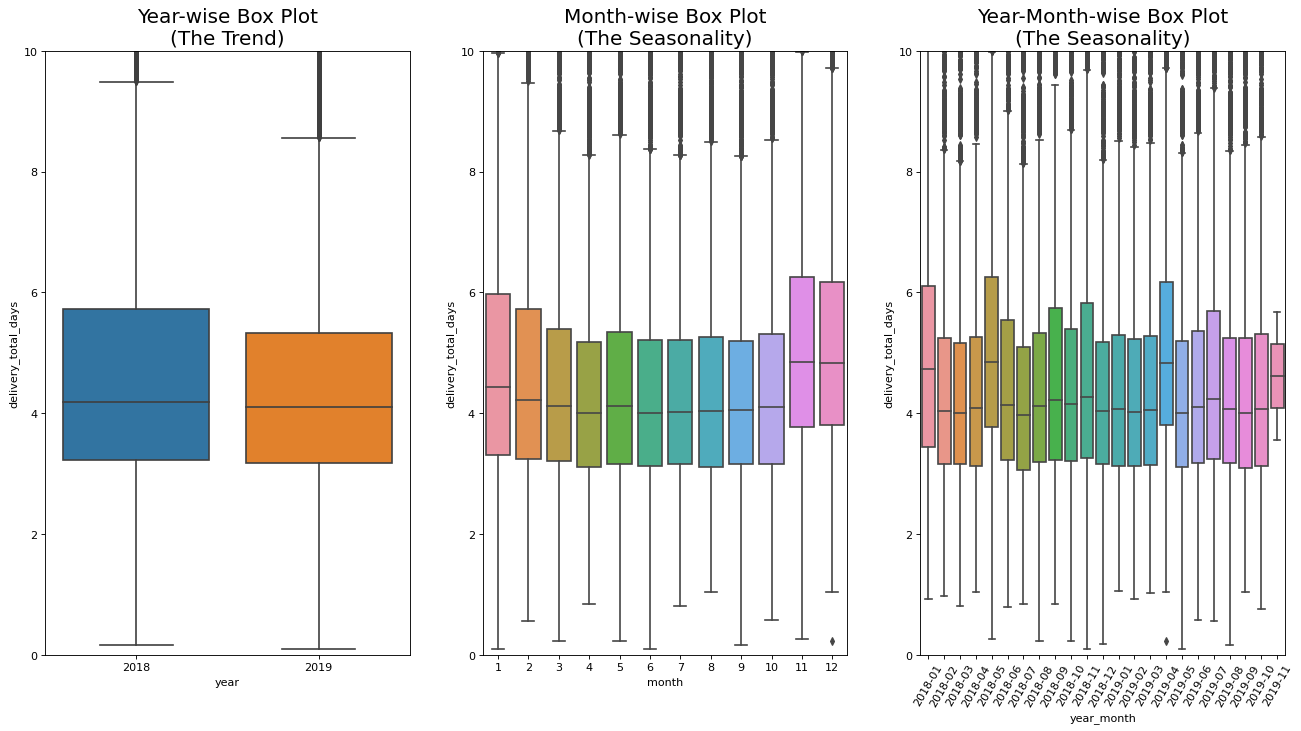

In [ ]:
trainsample2['year'] = [d.year for d in trainsample2.payment_datetime_buyer_no_tz]
trainsample2['month'] = [d.month for d in trainsample2.payment_datetime_buyer_no_tz]
trainsample2['year_month'] = trainsample2['payment_datetime_buyer_no_tz'].dt.to_period('M')

years = trainsample2['year'].unique()
year_month = sorted(trainsample2['year_month'].unique())

# Draw Plot
fig, axes = plt.subplots(1, 3, figsize=(20,10), dpi= 80)
sns.boxplot(x='year', y='delivery_total_days', data=trainsample2, ax=axes[0])
sns.boxplot(x='month', y='delivery_total_days', data=trainsample2, ax = axes[1])
sns.boxplot(x='year_month', y='delivery_total_days', data=trainsample2, ax = axes[2])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18)
axes[0].set_ylim([0, 10])  
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
axes[1].set_ylim([0, 10])  
axes[2].set_title('Year-Month-wise Box Plot\n(The Seasonality)', fontsize=18)
axes[2].set_ylim([0, 10]) 
axes[2].set_xticklabels(year_month, rotation = 60)
plt.show()

### EDA and comparison of delivery days by other variables

C2C is slower than B2C for more than 0.3 days, the main difference lies in handling days.

In [ ]:
trainsample2.groupby(['b2c_c2c'])['delivery_total_days'].mean()

b2c_c2c
B2C    4.699931
C2C    5.030936
Name: delivery_total_days, dtype: float64

In [ ]:
trainsample2.groupby(['b2c_c2c'])['actual_handling_days'].mean()

b2c_c2c
B2C    1.641328
C2C    1.932693
Name: actual_handling_days, dtype: float64

In [ ]:
trainsample2['seller_id'].nunique()

460157

In [ ]:
trainsample2.groupby(['shipment_method_id'])['delivery_total_days'].mean()

shipment_method_id
0     4.683598
1     4.468223
2     5.571731
3     6.750678
4     5.858620
5     4.062135
6     4.236316
7     4.452170
8     4.286488
9     4.622602
10    4.131544
11    3.499975
12    6.244306
13    2.844798
15    5.518444
Name: delivery_total_days, dtype: float64

In [ ]:
cuts = pd.cut(trainsample2['shipping_fee'], [0,0.01,5,10,15,20,25,50])
trainsample2.groupby(cuts)['delivery_total_days'].mean()

shipping_fee
(0.0, 0.01]     5.640806
(0.01, 5.0]     5.010120
(5.0, 10.0]     4.583780
(10.0, 15.0]    4.658982
(15.0, 20.0]    5.014751
(20.0, 25.0]    5.314212
(25.0, 50.0]    5.660518
Name: delivery_total_days, dtype: float64

In [ ]:
trainsample2.groupby(['category_id'])['delivery_total_days'].mean()

category_id
0     4.617184
1     4.570550
2     4.726507
3     4.910134
4     4.774880
5     4.561383
6     4.501982
7     4.998895
8     4.746773
9     4.802255
10    4.550863
11    4.526563
12    4.599408
13    4.620215
14    6.556609
15    4.903316
16    5.866370
17    4.860375
18    6.352852
19    4.465107
20    4.835632
21    4.577072
22    4.554740
23    4.868147
24    5.404691
25    6.931191
26    4.830542
27    5.053218
28    4.368687
29    5.747763
30    4.998997
31    4.692557
32    4.034232
Name: delivery_total_days, dtype: float64

### Model Selection: Regression models
### Ridge, Lasso, Catboost, RandomForest Regression, LightGBM Regression, Gradient Boosting Regression

In [27]:
trainsample2.columns

Index(['b2c_c2c', 'seller_id', 'declared_handling_days', 'acceptance_scan_timestamp', 'shipment_method_id', 'shipping_fee', 'carrier_min_estimate', 'carrier_max_estimate', 'item_zip', 'buyer_zip', 'category_id', 'item_price', 'quantity', 'payment_datetime', 'delivery_date', 'weight', 'weight_units', 'package_size', 'record_number', 'item_lat', 'item_lng', 'popu_dens_item', 'med_income_item', 'buyer_lat', 'buyer_lng', 'popu_dens_buyer', 'med_income_buyer', 'estimated_dist', 'payment_datetime_utc', 'acceptance_scan_timestamp_utc', 'actual_handling_days', 'handling_days_diff', 'zipcode', 'state', 'buyer_time_zone', 'payment_datetime_buyer', 'acceptance_scan_timestamp_buyer', 'delivery_datetime_assum', 'payment_datetime_buyer_no_tz', 'acceptance_scan_timestamp_buyer_no_tz', 'delivery_total_days'], dtype='object')

In [28]:
selected_features = trainsample2[['b2c_c2c', 'seller_id', 'declared_handling_days','shipment_method_id', 'shipping_fee',
       'carrier_min_estimate', 'carrier_max_estimate', 'item_zip', 'buyer_zip','category_id', 'item_price', 'quantity','weight',
       'package_size','actual_handling_days','estimated_dist','popu_dens_item', 'med_income_item', 'popu_dens_buyer', 'med_income_buyer']]
y = trainsample2['delivery_total_days']
selected_features.head()

,b2c_c2c,seller_id,declared_handling_days,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,category_id,item_price,quantity,weight,package_size,actual_handling_days,estimated_dist,popu_dens_item,med_income_item,popu_dens_buyer,med_income_buyer
0,B2C,1761,1.0,0,0.00,3,5,91706,90717,19,26.99,1,0,NONE,0.894491,28.826940,5699.000000,51232.000000,10767.000000,58320.00000
1,B2C,21502,3.0,3,0.00,2,8,230022,92028,6,5.60,1,0,NONE,1.688426,1089.228112,4553.395931,60125.679263,490.000000,61067.00000
2,B2C,898,1.0,0,0.00,3,5,90017,15712,1,19.95,1,4,PACKAGE_THICK_ENVELOPE,1.358576,2188.794555,32725.000000,21030.000000,93.000000,21023.00000
3,C2C,386410,1.0,0,2.95,3,5,37930,07087,19,6.57,1,0,PACKAGE_THICK_ENVELOPE,0.753275,1089.228112,4553.395931,60125.679263,3545.450529,58037.26973
4,B2C,1750,1.0,0,0.00,3,5,85027,23322,1,6.75,1,0,PACKAGE_THICK_ENVELOPE,0.939410,2019.699107,2642.000000,51919.000000,401.000000,96091.00000


#### Ordinal Encoding seller_id, item_zip, buyer_zip (Skip if using Catboost)

In [ ]:
def ordinal_encoding(data):
  objlist =['seller_id', 'item_zip', 'buyer_zip', 'category_id']
  ord_enc = OrdinalEncoder()
  data_str = data.loc[:,objlist]
  data_ord = ord_enc.fit_transform(data_str)
  del data_str
  data_ord = pd.DataFrame(data_ord, columns=objlist)
  data_ord = data_ord.astype("category") # concat later
  return data_ord

In [ ]:
to_concat = ordinal_encoding(selected_features)

In [ ]:
selected_features = selected_features.drop(columns = ['seller_id', 'item_zip', 'buyer_zip', 'category_id'])
selected_features.reset_index(drop=True, inplace=True)
to_concat.reset_index(drop=True, inplace=True)
selected_features = pd.concat([selected_features, to_concat], axis = 1)
del to_concat

#### Get Dummies b2c_c2c, package_size (Skip if using Catboost)

In [ ]:
selected_features = pd.get_dummies(data = selected_features, columns = ['b2c_c2c', 'package_size'])

### Train-test Split

In [29]:
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

In [30]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(selected_features, y, test_size=0.2, random_state=1)

### CatBoost

In [ ]:
!pip install catboost
!pip install shap

import catboost as cb
import seaborn as sns
import shap

In [ ]:
#  Identify columns with categorical features
categorical_features_indices = [0, 1, 3, 7, 8, 9, 13]  

# Model
model = cb.CatBoostRegressor()
model.fit(    
     X_train,
     y_train,
     cat_features=categorical_features_indices,
     eval_set=(X_test, y_test),
     verbose=False,
     plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 1.81
R2: 0.66


Loss Function: Calculate loss days (mean days deviating from the actual delivery date)

In [ ]:
print(mean_squared_error(y_test, pred))           # Calculate the test MSE
diff = pd.Series(pred - y_test)
abs_diff = pd.Series(abs(pred - y_test))
diff_sign = diff.apply(lambda x: 1 if x > 0 else 0)
diff_df = pd.DataFrame({'diff':diff, 'abs_diff':abs_diff, 'diff_sign':diff_sign})
loss_days = (diff_df[diff_df['diff_sign'] == 1]['abs_diff'].sum() * 0.4 + diff_df[diff_df['diff_sign'] == 0]['abs_diff'].sum() * 0.6)/diff_df.shape[0]
loss_days

3.2935522877882155


0.47786233228228064

### Ridge Model

In [ ]:
ridge = Ridge(alpha = 0)
ridge.fit(X_train, y_train)
pred = ridge.predict(X_test)
print(pd.Series(ridge.coef_, index = selected_features.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))           # Calculate the test MSE

In [ ]:
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 1.53
R2: 0.75


Loss Function: Calculate loss days (mean days deviating from the actual delivery date)

In [ ]:
diff = pd.Series(pred - y_test)
abs_diff = pd.Series(abs(pred - y_test))
diff_sign = diff.apply(lambda x: 1 if x > 0 else 0)
diff_df = pd.DataFrame({'diff':diff, 'abs_diff':abs_diff, 'diff_sign':diff_sign})
loss_days = (diff_df[diff_df['diff_sign'] == 1]['abs_diff'].sum() * 0.4 + diff_df[diff_df['diff_sign'] == 0]['abs_diff'].sum() * 0.6)/diff_df.shape[0]
loss_days

0.5068658448621424

### Lasso Regression

In [ ]:
lasso = Lasso(alpha = 1.0)
lasso.fit(X_train, y_train)
pred = lasso.predict(X_test)
print(pd.Series(lasso.coef_, index = selected_features.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))           # Calculate the test MSE

declared_handling_days                 0.000000e+00
shipment_method_id                     0.000000e+00
shipping_fee                          -0.000000e+00
carrier_min_estimate                  -0.000000e+00
carrier_max_estimate                   0.000000e+00
item_price                            -3.142115e-04
quantity                              -0.000000e+00
weight                                 0.000000e+00
actual_handling_days                   8.413625e-01
estimated_dist                         3.202244e-04
seller_id                              2.766089e-07
item_zip                              -3.864859e-06
buyer_zip                              3.128160e-06
category_id                            0.000000e+00
b2c_c2c_B2C                           -0.000000e+00
b2c_c2c_C2C                            0.000000e+00
package_size_LARGE_ENVELOPE           -0.000000e+00
package_size_LARGE_PACKAGE             0.000000e+00
package_size_LETTER                    0.000000e+00
package_size

In [ ]:
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 1.64
R2: 0.72


In [ ]:
diff = pd.Series(pred - y_test)
abs_diff = pd.Series(abs(pred - y_test))
diff_sign = diff.apply(lambda x: 1 if x > 0 else 0)
diff_df = pd.DataFrame({'diff':diff, 'abs_diff':abs_diff, 'diff_sign':diff_sign})
loss_days = (diff_df[diff_df['diff_sign'] == 1]['abs_diff'].sum() * 0.4 + diff_df[diff_df['diff_sign'] == 0]['abs_diff'].sum() * 0.6)/diff_df.shape[0]
loss_days

0.5421684700958057

### Random Forest Regressor

In [ ]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
 # create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
# fit the regressor with x and y data
regressor.fit(X_train, y_train)
pred = ridge.predict(X_test)

In [ ]:
print(mean_squared_error(y_test, pred))           # Calculate the test MSE
diff = pd.Series(pred - y_test)
abs_diff = pd.Series(abs(pred - y_test))
diff_sign = diff.apply(lambda x: 1 if x > 0 else 0)
diff_df = pd.DataFrame({'diff':diff, 'abs_diff':abs_diff, 'diff_sign':diff_sign})
loss_days = (diff_df[diff_df['diff_sign'] == 1]['abs_diff'].sum() * 0.4 + diff_df[diff_df['diff_sign'] == 0]['abs_diff'].sum() * 0.6)/diff_df.shape[0]
loss_days

2.27122067965516


0.5041624090751999

### LGBM Regressor

In [ ]:
import lightgbm as lgb

In [ ]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.05,
    "max_depth": 8,
    "num_leaves": 128,  
    "n_estimators": 500
}

In [ ]:
gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.05, max_depth=8, metric=['l1', 'l2'],
              n_estimators=500, num_leaves=128, objective='regression',
              task='train')

In [ ]:
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 1.64
R2: 0.70


In [ ]:
pred = gbm.predict(X_test)
print(mean_squared_error(y_test, pred))           # Calculate the test MSE
diff = pd.Series(pred - y_test)
abs_diff = pd.Series(abs(pred - y_test))
diff_sign = diff.apply(lambda x: 1 if x > 0 else 0)
diff_df = pd.DataFrame({'diff':diff, 'abs_diff':abs_diff, 'diff_sign':diff_sign})
loss_days = (diff_df[diff_df['diff_sign'] == 1]['abs_diff'].sum() * 0.4 + diff_df[diff_df['diff_sign'] == 0]['abs_diff'].sum() * 0.6)/diff_df.shape[0]
loss_days

3.6071412165750867


0.5056834572521587

### Gradient Boosting Regression

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gbr_params = {'n_estimators': 500,
          'max_depth': 3,
          'min_samples_split': 5,
          'learning_rate': 0.05}

# Create an instance of gradient boosting regressor

gbr = GradientBoostingRegressor(**gbr_params)

# Fit the model
gbr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, min_samples_split=5,
                          n_estimators=500)

In [ ]:
pred = gbr.predict(X_test)

In [ ]:
print(mean_squared_error(y_test, pred))           # Calculate the test MSE
diff = pd.Series(pred - y_test)
abs_diff = pd.Series(abs(pred - y_test))
diff_sign = diff.apply(lambda x: 1 if x > 0 else 0)
diff_df = pd.DataFrame({'diff':diff, 'abs_diff':abs_diff, 'diff_sign':diff_sign})
loss_days = (diff_df[diff_df['diff_sign'] == 1]['abs_diff'].sum() * 0.4 + diff_df[diff_df['diff_sign'] == 0]['abs_diff'].sum() * 0.6)/diff_df.shape[0]
loss_days

2.085137810023019


0.46922773206721935

### After experimenting with different regression models <br>We choose Catboost and Ridge models to experiment on quiz dataset to see the actual loss days.

### Read quiz test set

In [ ]:
quiz = pd.read_csv("/content/drive/Shareddrives/eBay/quiz.tsv",sep = "\t")

In [ ]:
quiz = fill_na(quiz)
print(quiz.shape)

(2500000, 19)


### Data cleaning

In [ ]:
quiz = tidy_zip(quiz, 'item_zip')
quiz = tidy_zip(quiz, 'buyer_zip')
quiz = quiz.reset_index().drop(columns = 'index')
print(quiz.shape)

In [ ]:
quiz = calculate_actual_handling_days(quiz)
print(quiz.shape)

(2500000, 23)


### Sync time zones

In [ ]:
quiz = quiz.merge(uszip[['zipcode','state']], left_on = 'buyer_zip', right_on = 'zipcode', how = 'left')

In [ ]:
quiz['buyer_time_zone'] = quiz['state'].apply(lambda x: get_time_zone(x))
quiz['buyer_time_zone'] = quiz['buyer_time_zone'].fillna('US/Central')

# Since the delivery date is in the local timezone of the buyer, and only specify to days
# So convert payment_datetime and acceptance_scan_timestamp to buyer timezone
# Thus, the delivery total time can be calculated
quiz = convert_to_buyer_tz(quiz, 'payment_datetime_utc', 'US/Pacific')
quiz = convert_to_buyer_tz(quiz, 'payment_datetime_utc', 'US/Mountain')
quiz = convert_to_buyer_tz(quiz, 'payment_datetime_utc', 'US/Central')
quiz = convert_to_buyer_tz(quiz, 'payment_datetime_utc', 'US/Eastern')
quiz = convert_to_buyer_tz(quiz, 'payment_datetime_utc', 'US/Alaska')
quiz = convert_to_buyer_tz(quiz, 'payment_datetime_utc', 'US/Hawaii')

quiz = convert_to_buyer_tz(quiz, 'acceptance_scan_timestamp_utc', 'US/Pacific')
quiz = convert_to_buyer_tz(quiz, 'acceptance_scan_timestamp_utc', 'US/Mountain')
quiz = convert_to_buyer_tz(quiz, 'acceptance_scan_timestamp_utc', 'US/Central')
quiz = convert_to_buyer_tz(quiz, 'acceptance_scan_timestamp_utc', 'US/Eastern')
quiz = convert_to_buyer_tz(quiz, 'acceptance_scan_timestamp_utc', 'US/Alaska')
quiz = convert_to_buyer_tz(quiz, 'acceptance_scan_timestamp_utc', 'US/Hawaii')
quiz.shape

(2500000, 28)

In [ ]:
def sync_time_quiz(data): 
  # Remove timezone information to ensure same time format
  data['payment_datetime_buyer_no_tz'] = data['payment_datetime_buyer'].apply(lambda x:x.replace(tzinfo = None))
  data['acceptance_scan_timestamp_buyer_no_tz'] = data['acceptance_scan_timestamp_buyer'].apply(lambda x:x.replace(tzinfo = None))
  return data

In [ ]:
quiz = sync_time_quiz(quiz)
quiz.shape

(2500000, 30)

### Feature engineering: add new features: estimated distance, population and income

In [ ]:
quiz = map_coordinates(quiz) 
quiz.shape

(2500000, 38)

In [ ]:
quiz['estimated_dist'] = itertuples_impl(quiz)
quiz['estimated_dist'] = quiz['estimated_dist'].fillna(quiz['estimated_dist'].mean())

In [ ]:
selected_features_quiz = quiz[['b2c_c2c', 'seller_id', 'declared_handling_days','shipment_method_id', 'shipping_fee',
       'carrier_min_estimate', 'carrier_max_estimate', 'item_zip', 'buyer_zip','category_id', 'item_price', 'quantity','weight',
       'package_size','actual_handling_days','estimated_dist','popu_dens_item', 'med_income_item', 'popu_dens_buyer', 'med_income_buyer']]

#### Encoding Part (Skip if using Catboost)

In [ ]:
to_concat = ordinal_encoding(selected_features_quiz)

In [ ]:
selected_features_quiz = selected_features_quiz.drop(columns = ['seller_id', 'item_zip', 'buyer_zip', 'category_id'])
selected_features_quiz.reset_index(drop=True, inplace=True)
to_concat.reset_index(drop=True, inplace=True)
selected_features_quiz = pd.concat([selected_features_quiz, to_concat], axis = 1)
del to_concat

In [ ]:
selected_features_quiz = pd.get_dummies(data = selected_features_quiz, columns = ['b2c_c2c', 'package_size'])

#### Predict on quiz set

In [ ]:
predicted_delivery_days = list(ridge.predict(selected_features_quiz))

In [ ]:
predicted_delivery_days = pd.Series(model.predict(selected_features_quiz))

In [ ]:
quiz['predicted days'] = pd.to_timedelta(predicted_delivery_days,'d')
quiz['delivery_date'] = quiz['payment_datetime_buyer_no_tz'] + quiz['predicted days']
quiz['delivery_date'] = quiz['delivery_date'].dt.strftime('%Y-%m-%d')

In [ ]:
result = quiz[['record_number','delivery_date']]
result = result.rename(columns = {'record_number':'record identifier','delivery_date':'predicted delivery date'})
result

,record identifier,predicted delivery date
0,15000001,2019-11-18
1,15000002,2019-12-01
2,15000003,2019-12-06
3,15000004,2019-12-17
4,15000005,2019-12-22
...,...,...
2499995,17499996,2019-12-23
2499996,17499997,2019-12-09
2499997,17499998,2019-12-08
2499998,17499999,2019-12-13


In [ ]:
result.to_csv("/content/drive/Shareddrives/eBay/result_0102.tsv", sep = '\t',index=False, header = False)

In [ ]:
test = pd.read_csv("/content/drive/Shareddrives/eBay/result_0102.tsv",sep = "\t")
test

,15000001,2019-11-18
0,15000002,2019-12-01
1,15000003,2019-12-06
2,15000004,2019-12-17
3,15000005,2019-12-22
4,15000006,2019-12-02
...,...,...
2499994,17499996,2019-12-23
2499995,17499997,2019-12-09
2499996,17499998,2019-12-08
2499997,17499999,2019-12-13


### Export to tsv.gz format

In [ ]:
import gzip
import shutil
with open('/content/drive/Shareddrives/eBay/result_0102.tsv', 'rb') as f_in:
    with gzip.open('/content/drive/Shareddrives/eBay/result_0102.tsv.gz', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)